- Goal is to compare sklearn linear regression algo vs SageMaker linear model algo (type="regressor")
- In particular interested in differences when training and validating

In [1]:
# !pip install tensorflow 

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
URL = "https://vincentarelbundock.github.io/Rdatasets/csv/carData/Salaries.csv"
data = pd.read_csv(URL)
data.head()

,Unnamed: 0,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,1,Prof,B,19,18,Male,139750
1,2,Prof,B,20,16,Male,173200
2,3,AsstProf,B,4,3,Male,79750
3,4,Prof,B,45,39,Male,115000
4,5,Prof,B,40,41,Male,141500


In [3]:
data.drop(['Unnamed: 0', 'discipline'], axis=1, inplace=True)
data.head()

,rank,yrs.since.phd,yrs.service,sex,salary
0,Prof,19,18,Male,139750
1,Prof,20,16,Male,173200
2,AsstProf,4,3,Male,79750
3,Prof,45,39,Male,115000
4,Prof,40,41,Male,141500


In [4]:
data['rank'].unique()

array(['Prof', 'AsstProf', 'AssocProf'], dtype=object)

In [5]:
data.dtypes

rank             object
yrs.since.phd     int64
yrs.service       int64
sex              object
salary            int64
dtype: object

In [6]:
data['salary'].describe()

count       397.000000
mean     113706.458438
std       30289.038695
min       57800.000000
25%       91000.000000
50%      107300.000000
75%      134185.000000
max      231545.000000
Name: salary, dtype: float64

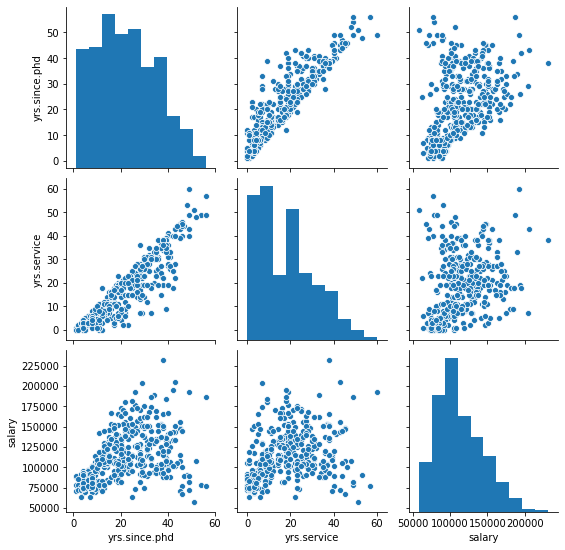

In [7]:
sns.pairplot(data)
plt.show()

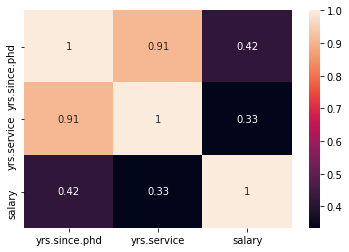

In [8]:
sns.heatmap(data.corr(), annot=True)

In [9]:
data.columns

Index(['rank', 'yrs.since.phd', 'yrs.service', 'sex', 'salary'], dtype='object')

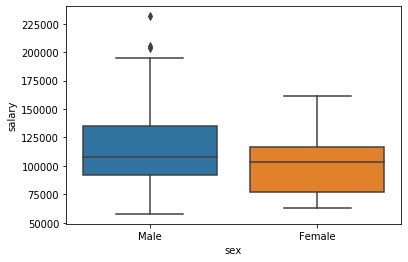

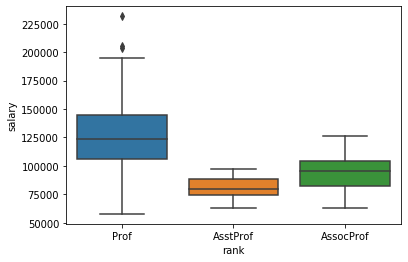

In [10]:
sns.boxplot(x='sex', y='salary', data=data)
plt.show()

sns.boxplot(x='rank', y='salary', data=data)
plt.show()

In [11]:
data.drop('yrs.since.phd', axis=1, inplace=True)
data = pd.get_dummies(data, drop_first=True)
data.head()

,yrs.service,salary,rank_AsstProf,rank_Prof,sex_Male
0,18,139750,0,1,1
1,16,173200,0,1,1
2,3,79750,1,0,1
3,39,115000,0,1,1
4,41,141500,0,1,1


In [12]:
data.head()

,yrs.service,salary,rank_AsstProf,rank_Prof,sex_Male
0,18,139750,0,1,1
1,16,173200,0,1,1
2,3,79750,1,0,1
3,39,115000,0,1,1
4,41,141500,0,1,1


In [13]:
X = data.drop(['salary'], axis=1).to_numpy('float32')
y = data[['salary']].to_numpy('float32').flatten()

In [14]:
print(X.shape, y.shape)

(397, 4) (397,)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let us train a linear regression model in sklearn first. 

In [16]:
from sklearn.linear_model import LinearRegression

sklearn_model = LinearRegression(fit_intercept=True)
sklearn_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
sklearn_r2 = sklearn_model.score(X_test, y_test)
sklearn_r2

0.2978138284258993

In [18]:
from sklearn.metrics import mean_squared_error

sklearn_rmse = np.sqrt(mean_squared_error(y_test, sklearn_model.predict(X_test)))
sklearn_rmse

23331.94

In [19]:
print('Linear Model Coefficients (intercept): ', sklearn_model.intercept_)
print('Linear Model Coefficients (intercept): ', sklearn_model.coef_)


Linear Model Coefficients (intercept):  92436.68
Linear Model Coefficients (intercept):  [  -241.61987 -14206.943    37609.316     3462.835  ]


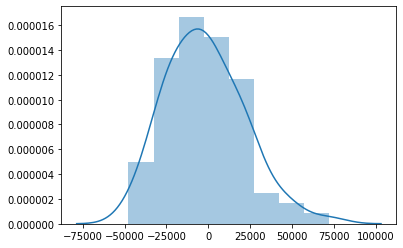

In [20]:
# let us look at the histogram of the errors
errors = y_test - sklearn_model.predict(X_test)
sns.distplot(errors)

Now, let us use SageMaker.

In [21]:
import boto3
import sagemaker


sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-studio-ehsxkd5xxqm'
prefix = 'linear_learner'

role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::569429297813:role/service-role/AmazonSageMaker-ExecutionRole-20200812T185815


In [22]:
import io
import numpy as np
import sagemaker.amazon.common as smac # sagemaker common library

# Converts data in numpy array format to RecordIO format
# This is required for Linear Learner
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train.flatten())
buf.seek(0)

0

In [23]:
import os

# upload RecordIO data to S3

# name of file
key = 'linear-train-data'

# uploading
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)


In [24]:
s3_train_data = f's3://{bucket}/{prefix}/train/{key}'
print(f'The data is stored at: {s3_train_data}')

The data is stored at: s3://sagemaker-studio-ehsxkd5xxqm/linear_learner/train/linear-train-data


In [25]:
output_location = f's3://{bucket}/{prefix}/output'
print(f'Training output will be stored at: {output_location}')

Training output will be stored at: s3://sagemaker-studio-ehsxkd5xxqm/linear_learner/output


In [26]:
# Let's obtain a reference to the linearLearner container image
# The below is used to get the training container of sagemaker built-in algorithms
# all we have to do is specify the name of the algorithm, that we want to use

# Note that all regression models are names estimators
# You don't have to specify/hardcode the region, get_image_uri will get the current region name

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [34]:
# We pass to the container the type of instance we want for training
# We can also provide output path and sagemaker session into the Estimator
# Also can specify how many instances we would like to use for training

linear = sagemaker.estimator.Estimator(container, 
                                      role,
                                      train_instance_count=1,
                                      train_instance_type='ml.c4.xlarge',
                                      output_path = output_location,
                                      sagemaker_session = sagemaker_session,
                                      train_use_spot_instances=True, 
                                      train_max_run=1000, 
                                       train_max_wait=1000,
                                      )

# For hyperparameter tuning
linear.set_hyperparameters(feature_dim=X.shape[1],
                          predictor_type='regressor',
                          mini_batch_size=32,
                          epochs=3,
                          num_models=3,
                          loss='absolute_loss')

In [35]:
# Now that we have set up the model, let us pass training data from s3

linear.fit({'train': s3_train_data})

2020-08-14 02:21:05 Starting - Starting the training job...
2020-08-14 02:21:07 Starting - Launching requested ML instances......
2020-08-14 02:22:21 Starting - Preparing the instances for training.........
2020-08-14 02:24:02 Downloading - Downloading input data
2020-08-14 02:24:02 Training - Downloading the training image...
2020-08-14 02:24:35 Uploading - Uploading generated training model
2020-08-14 02:24:35 Completed - Training job completed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/14/2020 02:24:26 INFO 140493828642624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_lev

In [ ]:
# How can we reduce the cost of billable seconds???
# Do the following:

#linear = sagemaker.estimator.Estimator(container, 
                                    #  role,
                                    #  train_instance_count=1,
                                    #  train_instance_type='ml.c4.xlarge',
                                    #  output_path=output_location,
                                    #  sagemaker_session=sagemaker_session,
                                    #  train_use_spot_instances=True, # use spot instances, unused ec2 instances available (not on demand -- so you might wait)
                                    #  train_max_run=300, # time out in seconds for training
                                    #  train_max_wait=600) # wait in seconds until spot instance is available, if time is up use on demand


In [36]:
linear_regressor = linear.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge')

-----------------!

In [39]:
from sagemaker.predictor import csv_serializer, json_deserializer

# content type overrides the data that will be passed to the deployed model, since the deployed model
# expects in txt/csv format
linear_regressor.content_type = 'text/csv'

# Serializer accepts a single argument, the input data, and returns a sequence of bytes
linear_regressor.serializer = csv_serializer

# Deserializer accepts two arguments, the result data and the content type, and returns a sequence of bytes
linear_regressor.deserializer = json_deserializer

In [40]:
result = linear_regressor.predict(X_test)
result # in json format

{'predictions': [{'score': 114502.5625},
  {'score': 116384.15625},
  {'score': 90880.7578125},
  {'score': 111008.15625},
  {'score': 119072.15625},
  {'score': 118265.7578125},
  {'score': 116921.7578125},
  {'score': 113696.15625},
  {'score': 112083.359375},
  {'score': 111814.5625},
  {'score': 90074.359375},
  {'score': 120953.7578125},
  {'score': 100887.2265625},
  {'score': 115577.7578125},
  {'score': 101693.6328125},
  {'score': 116921.7578125},
  {'score': 116115.359375},
  {'score': 90611.9609375},
  {'score': 87832.609375},
  {'score': 90611.9609375},
  {'score': 115040.15625},
  {'score': 113696.15625},
  {'score': 87832.609375},
  {'score': 110470.5625},
  {'score': 113696.15625},
  {'score': 112352.15625},
  {'score': 115040.15625},
  {'score': 98376.6875},
  {'score': 112083.359375},
  {'score': 119340.9609375},
  {'score': 118534.5625},
  {'score': 113964.9609375},
  {'score': 106263.2265625},
  {'score': 116921.7578125},
  {'score': 111276.9609375},
  {'score': 1128

In [41]:
predictions = np.array([r['score'] for r in result['predictions']])
predictions

array([114502.5625   , 116384.15625  ,  90880.7578125, 111008.15625  ,
       119072.15625  , 118265.7578125, 116921.7578125, 113696.15625  ,
       112083.359375 , 111814.5625   ,  90074.359375 , 120953.7578125,
       100887.2265625, 115577.7578125, 101693.6328125, 116921.7578125,
       116115.359375 ,  90611.9609375,  87832.609375 ,  90611.9609375,
       115040.15625  , 113696.15625  ,  87832.609375 , 110470.5625   ,
       113696.15625  , 112352.15625  , 115040.15625  ,  98376.6875   ,
       112083.359375 , 119340.9609375, 118534.5625   , 113964.9609375,
       106263.2265625, 116921.7578125, 111276.9609375, 112889.7578125,
       111814.5625   ,  90611.9609375, 115040.15625  ,  90880.7578125,
       113964.9609375,  99005.6328125, 110470.5625   , 101424.828125 ,
       119072.15625  , 118534.5625   , 111814.5625   , 109841.609375 ,
       120416.15625  , 113158.5625   , 101962.4296875, 118803.359375 ,
       100080.828125 ,  88370.2109375, 111545.7578125, 111908.03125  ,
      

In [42]:
predictions.shape

(80,)

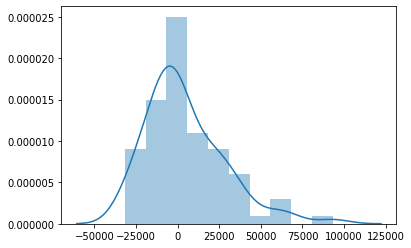

In [44]:
errors = y_test - predictions
sns.distplot(errors)

In [45]:
np.sqrt(mean_squared_error(y_test, predictions))

24174.778649281543

In [48]:
linear_regressor.delete_endpoint()